In [9]:
from typing import Callable, List, Tuple

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions.distribution import Distribution
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [10]:
from NFconstants import N_nod, Beta, a, K_nod
from NFandist import get_O
from NFandist import get_diag
from NFandist import get_C
from Data import normal_dist

def set_random_seed(seed):
    torch.manual_seed(seed)
O=(torch.tensor(get_O(N_nod)).float()).to(device)
Ot=(torch.t(O)).to(device)
print(Ot.requires_grad)


#C=(torch.tensor(get_C(N_nod,Beta)).float()).to(device)
#Ct=(torch.t(C)).to(device)




False


In [11]:
class AffineCouplingLayer(nn.Module):
    def __init__(
        self,
        theta: nn.Module,
        split,
        swap: int
    ):
        super().__init__()
        self.theta = theta
        self.split = split
        self.swap = swap

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        """g : z -> x. The inverse of f."""
        mask1=self.split[self.swap]
        mask2=self.split[(self.swap+1)%2]
        z1, z2 = z[:,mask1], z[:,mask2]
        z1=torch.cat((z1,params),dim=-1)
        t, s = self.theta(z1)
        x2 = z2 * torch.exp(s) + t
        log_det = s.sum(-1) 
        z[:,mask2]=x2
        return z, log_det
    """
    def f(self, x: torch.Tensor) -> torch.Tensor:
        f : x -> z. The inverse of g.
        x2, x1 = self.split(x,self.swap)
        t, s = self.theta(x1)
        z1, z2 = x1, x2 * torch.exp(s) + t 
        log_det = s.sum(-1) 
        return torch.cat((z1, z2), dim=-1), log_det
    """    

In [12]:
class D(nn.Linear):
    def __init__(self,n):
        super().__init__(n,1,bias=False)
        self.n=n
        self.d_ind=[(n+1)*k for k in range(n)]
    
    def anti_flatten(self):
        n=self.n
        D=torch.zeros((n**2)).to(device)
        D[self.d_ind]=self.weight.to(device)
        D=torch.reshape(D,(n,n)).to(device)
        return D        
            
    def log_abs_det(self):
        ABS=torch.abs(self.weight)
        l=torch.log(ABS)
        lad=torch.sum(l)
        return lad
    
    def forward(self,x):
        D=(self.anti_flatten()).to(x.device)
        return torch.matmul(x,D)
    
    def g(self,z,params):
        lad=self.log_abs_det()
        return self.forward(z),  lad * torch.ones((z.shape[0])).to(z.device)
        
    def adj(self,mat):
        Lw=self.anti_flatten()
        Lwt=torch.t(Lw)
        D=torch.matmul(Lwt,torch.matmul(mat,Lw))
        return D
    

In [13]:
class CubicCouplingLayer(nn.Module):
    def __init__(
        self,
        theta,
        split,
        swap: int,
        reg=1
    ):
        super().__init__()
        self.theta = theta
        self.split = split
        self.swap = swap
        self.reg=reg
        
    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        """g : z -> x. The inverse of f."""
        mask1=self.split[self.swap]
        mask2=self.split[(self.swap+1)%2]
        z1, z2 = z[:,mask1], z[:,mask2]
        z1=torch.cat((z1,params),dim=-1)
        t, s = self.theta(z1)
        x2 = z2 + torch.exp(s-self.reg) * (z2) ** 3 + t
        log_det = (torch.log(1+3 * torch.exp(s-self.reg) * (z2) ** 2)).sum(-1)
        z[:,mask2]=x2
        return z, log_det    



In [14]:
def get_split_masks(dim=N_nod):
    mask1=list(range(0,dim,2))
    mask2=list(range(1,dim,2))
    split_masks=[mask1,mask2]
    return split_masks
    

In [15]:
def get_pair_split_masks(dim=N_nod):
    mask1=list(range(0,dim,4))
    mask2=list(range(2,dim,4))
    mask1=(mask1+list(map(lambda x:x+1,mask1)))
    mask2=(mask2+list(map(lambda x:x+1,mask2)))
    mask1.sort()
    mask2.sort()
    split_masks=[mask1,mask2]
    return split_masks

In [16]:
class ThetaNetwork(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        num_hidden: int,
        hidden_dim: int,
        num_params: int,
        p_drop: float,
    ):
        super().__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.Dropout(p=p_drop),
                nn.LayerNorm(hidden_dim)
            ) for _ in range(num_hidden)]
        )

        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)
        
    def configure_theta(num_hidden,hidden_dim,p_drop,in_dim=N_nod//2,out_dim=N_nod//2):
        theta=ThetaNetwork(
                in_dim = in_dim,
                out_dim = out_dim,
                num_hidden = num_hidden,  #2 to 6
                hidden_dim = hidden_dim , #100-1024
                num_params = 2,
                p_drop=p_drop,
        )
        return theta    

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x),negative_slope=0.01)
        for h in self.hidden:
            x = F.leaky_relu(h(x),negative_slope=0.01)

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1) 
        params = batch_params.chunk(self.num_params, dim=-1) 
        return [p.squeeze(-1) for p in params]

In [17]:
class NormalizingFlow(nn.Module):
    
    def __init__(self, latent: Distribution, flows: List[nn.Module], conv_flows = [], ort=False):
        super().__init__()
        self.latent = latent
        self.flows = flows
        self.ort = ort
        self.conv_flows = conv_flows
        
    def configure_flows(n_flows,num_hidden,hidden_dim,p_drop,dim=N_nod,param_dim=0):  # n_flows=8,...,12
        flows = []
        split_masks_d = get_pair_split_masks(dim)
        #split_masks_d = get_split_masks(dim)
    
        for k in range(n_flows):
            theta = ThetaNetwork.configure_theta( num_hidden = num_hidden, hidden_dim = hidden_dim, p_drop=p_drop ,in_dim = dim//2+param_dim,out_dim = dim//2)
            flows.append(AffineCouplingLayer(theta,split=split_masks_d,swap=k%2))
   
        flows = nn.ModuleList(flows)
        return flows     

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        #x, sum_log_abs_det = z, torch.ones(z.size(0)).to(z.device)
        x, sum_log_abs_det = z, torch.zeros(z.size(0)).to(z.device)
        for flow in reversed(self.flows):
            x, log_abs_det = flow.g(x,params)
            sum_log_abs_det += log_abs_det
        
        if self.ort:
            x=torch.matmul(x,Ot.to(x.device))
        
        #x=x*a    
        
        for flow in reversed(self.conv_flows):
            x, log_abs_det = flow.g(x)
            sum_log_abs_det += log_abs_det
        return x, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    
 
"""
    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        Maps latent variable z to observation x
        and stores intermediate results.
        
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))
        return xs

    
    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        llp=self.latent.log_prob(z)
        sum_llp= torch.sum(llp,axis=-1)
        return sum_llp
 
    
    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:  #forward
        Maps observation x to latent variable z.
        Additionally, computes the log determinant
        of the Jacobian for this transformation.
        Inveres of g.
        
        z, sum_log_abs_det = x, torch.ones(x.size(0)).to(x.device)
        for flow in self.flows:
            z, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det

        return z, sum_log_abs_det
"""
    

'\n    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:\n        Maps latent variable z to observation x\n        and stores intermediate results.\n        \n        xs = [z]\n        for flow in reversed(self.flows):\n            xs.append(flow.g(xs[-1]))\n        return xs\n\n    \n    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:\n        llp=self.latent.log_prob(z)\n        sum_llp= torch.sum(llp,axis=-1)\n        return sum_llp\n \n    \n    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:  #forward\n        Maps observation x to latent variable z.\n        Additionally, computes the log determinant\n        of the Jacobian for this transformation.\n        Inveres of g.\n        \n        z, sum_log_abs_det = x, torch.ones(x.size(0)).to(x.device)\n        for flow in self.flows:\n            z, log_abs_det = flow.f(z)\n            sum_log_abs_det += log_abs_det\n\n        return z, sum_log_abs_det\n'

In [18]:
class RGflows(nn.Module):
    
    def __init__(self,latent: Distribution ,nflist, masks, n_flows_dict,num_hidden_dict,hidden_dim_dict):
        super().__init__()
        self.latent = latent
        self.nflist = nflist
        self.masks = masks
        self.n_flows_dict = n_flows_dict
        self.num_hidden_dict = num_hidden_dict
        self.hidden_dim_dict = hidden_dim_dict
        
    def configure_RG_flows(masks,n_flows_dict,num_hidden_dict,hidden_dim_dict,p_drop=0):  
        nflist=[]
        dim = len(masks[0])
        param_dim = 0
        for k in range(len(masks)):
            flows =  NormalizingFlow.configure_flows(n_flows = n_flows_dict[dim] , num_hidden = num_hidden_dict[dim] , hidden_dim = hidden_dim_dict[dim], dim = dim , param_dim = param_dim, p_drop = p_drop)
            nflist.append(NormalizingFlow(latent=normal_dist,flows=flows,ort=False))
            param_dim += dim 
            if k!=0: dim *= 2 
        nflist = nn.ModuleList(nflist)        
        return nflist    
        
    def configure_RG_model(latent,masks,n_flows_dict, num_hidden_dict,hidden_dim_dict,p_drop=0):
        flows=RGflows.configure_RG_flows(masks,n_flows_dict,num_hidden_dict,hidden_dim_dict,p_drop=p_drop)
        return RGflows(latent,flows,RGmasks,n_flows_dict,num_hidden_dict,hidden_dim_dict)
    
    def save(self,filename):
        state_dict = self.state_dict()
        model_dict={"state_dict":state_dict,
                    "n_flows_dict":self.n_flows_dict,
                    "num_hidden_dict":self.num_hidden_dict,
                    "hidden_dim_dict":self.hidden_dim_dict,
                    "masks":self.masks}
        torch.save(model_dict,filename)
    
    def load_model(filename):   
        model_dict = torch.load(filename,map_location = device)
        model=RGflows.configure_RG_model(normal_dist,
                                  model_dict["masks"],
                                  model_dict["n_flows_dict"], 
                                  model_dict["num_hidden_dict"],
                                  model_dict["hidden_dim_dict"],
                                  p_drop=0)
        model.load_state_dict(model_dict["state_dict"])
        return model
        

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        sum_log_abs_det = torch.zeros(z.size(0)).to(z.device)
        params=torch.tensor([]).to(z.device)
        for i in range(len(self.nflist)):
            x=z[:,self.masks[i]]
            x, log_abs_det = ((self.nflist)[i]).g(x,params)
            sum_log_abs_det += log_abs_det
            params=torch.cat((params,x.detach()),dim=-1)
            z[:,self.masks[i]]=x
        z = torch.matmul(z,Ot.to(z.device))    
        return z, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    
    def forward(self,z):
        with torch.no_grad():
            t=(z.clone()).to(z.device)
            x, log_abs_det=self.g(t)
            log_abs_det=log_abs_det.detach().to(z.device)
        return x, log_abs_det
    
 

    

In [19]:
def get_points(start,stop,step):
    if step == 0:
        print("step = 0 error")
        return 1
    x=start
    Y=[]
    while x < stop:
        Y.append(x)
        Y.append(x+1)
        x += step
    return Y


def config_RG_masks(m,n_nod):
    masks = []
    start = 0
    step = n_nod // (2 ** (m-1))
    tmp = get_points(start,n_nod,step)
    masks.append(tmp)
    if n_nod == 2 ** m:
        return masks
    start = step//2
    masks.append(get_points(start,n_nod,step))
    while step > 4:
        step //= 2
        start = step//2
        masks.append(get_points(start,n_nod,step))
    return masks
    

In [20]:
RGmasks = config_RG_masks(3,N_nod)

In [21]:
print(RGmasks)

[[0, 1, 64, 65, 128, 129, 192, 193], [32, 33, 96, 97, 160, 161, 224, 225], [16, 17, 48, 49, 80, 81, 112, 113, 144, 145, 176, 177, 208, 209, 240, 241], [8, 9, 24, 25, 40, 41, 56, 57, 72, 73, 88, 89, 104, 105, 120, 121, 136, 137, 152, 153, 168, 169, 184, 185, 200, 201, 216, 217, 232, 233, 248, 249], [4, 5, 12, 13, 20, 21, 28, 29, 36, 37, 44, 45, 52, 53, 60, 61, 68, 69, 76, 77, 84, 85, 92, 93, 100, 101, 108, 109, 116, 117, 124, 125, 132, 133, 140, 141, 148, 149, 156, 157, 164, 165, 172, 173, 180, 181, 188, 189, 196, 197, 204, 205, 212, 213, 220, 221, 228, 229, 236, 237, 244, 245, 252, 253], [2, 3, 6, 7, 10, 11, 14, 15, 18, 19, 22, 23, 26, 27, 30, 31, 34, 35, 38, 39, 42, 43, 46, 47, 50, 51, 54, 55, 58, 59, 62, 63, 66, 67, 70, 71, 74, 75, 78, 79, 82, 83, 86, 87, 90, 91, 94, 95, 98, 99, 102, 103, 106, 107, 110, 111, 114, 115, 118, 119, 122, 123, 126, 127, 130, 131, 134, 135, 138, 139, 142, 143, 146, 147, 150, 151, 154, 155, 158, 159, 162, 163, 166, 167, 170, 171, 174, 175, 178, 179, 182, 183

In [22]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

    """
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer
    """
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-9,
            factor=0.5,
            mode="min",
            threshold=0.1,
            patience = 1,
            verbose=True,
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "train_loss",
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        z = batch
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        self.log('train_loss', loss, prog_bar=True)
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [23]:
from NFoscillator import Oscillator
from NFrel_oscillator import Rel_Oscillator
from NFur_oscillator import Ur_Oscillator
from NFx4 import X4
from NFMorse import Morse
from NFrel_Morse import Rel_Morse
from NFrel_Columb import Rel_Columb
from NFnonrel_Columb import NonRel_Columb
from NFbadur_oscillator import BadUr_Oscillator
from NFtwowells import Two_wells
from NFcircle import Circle
from NFrel_twowells import Rel_two_wells 

osc=Oscillator(N_nod,Beta)
KL_osc=osc.get_KL()

rel1=Rel_Oscillator(N_nod,Beta,sigma=1)
KL_rel1=rel1.get_KL()

ur=Ur_Oscillator(N_nod,Beta)
KL_ur=ur.get_KL()

rel_columb=Rel_Columb(N_nod,Beta,alpha=1,R=1)
KL_rel_columb=rel_columb.get_KL()

tw = Two_wells(N_nod,Beta,g=1,x0=1.41)
KL_tw = tw.get_KL()


morse = Morse(N_nod,Beta,alpha=1)
KL_morse = morse.get_KL()

circ = Circle(N_nod,Beta,g=1,x0=4)
KL_circ = circ.get_KL()

rel_morse = Rel_Morse(N_nod,Beta,m=1,alpha=1)
KL_rel_morse = rel_morse.get_KL()

rel_tw = Rel_two_wells(N_nod,Beta,m=1,g=1,x0=1.41)
KL_rel_tw = rel_tw.get_KL()

KL_rel001=Rel_Oscillator(N_nod,Beta,sigma=0.01).get_KL()
KL_rel01=Rel_Oscillator(N_nod,Beta,sigma=0.1).get_KL()
KL_rel10=Rel_Oscillator(N_nod,Beta,sigma=10).get_KL()
KL_rel29=Rel_Oscillator(N_nod,Beta,sigma = 2 ** 9).get_KL()
KL_X4=X4(N_nod,Beta,g=0.05).get_KL()
KL_rel_morse=Rel_Morse(N_nod,Beta,alpha=1,m=1000).get_KL()
KL_nonrel_columb=NonRel_Columb(N_nod,Beta,alpha=1,R=1).get_KL()


In [24]:
class KL_mix(nn.Module):
    
    def __init__(self,KL1,KL2,alpha=0.5):
        super().__init__()
        self.KL1 = KL1
        self.KL2 = KL2
        self.alpha = alpha
    
    def forward(self,x,log_abs_det):
        n_nod = x.shape[1]
        N2 = self.KL2.n_nod
        step = n_nod//N2
        x1 = x[:,::step]
        loss = (1-self.alpha) * self.KL1(x,log_abs_det) + self.alpha * self.KL2(x1,log_abs_det) 
        return loss

In [25]:
rel8=Rel_Oscillator(8,Beta,sigma=1)
KL8=rel8.get_KL()
KL_rel_mix=KL_mix(KL_rel1,KL8,0.35)

In [26]:
ur8=Ur_Oscillator(8,Beta)
KLur8=ur8.get_KL()
KL_ur_mix=KL_mix(KL_ur,KLur8,0.35)

In [27]:
col8=Rel_Columb(8,Beta,alpha=1,R=1)
KLcol8=col8.get_KL()
KL_rel_columb_mix=KL_mix(KL_rel_columb,KLcol8,0.35)

In [28]:
hidden_dim_dict1={8:8,16:16,32:32,64:64,128:128,256:256}
n_flows_dict1={8:8,16:12,32:12,64:16,128:16,256:32}
num_hidden_dict1={8:6,16:6,32:12,64:12,128:16,256:32}

In [29]:
hidden_dim_dict2={8:8,16:16,32:16}
n_flows_dict2={8:16,16:16,32:16}
num_hidden_dict2={8:16,16:16,32:16}

In [30]:
hidden_dim_dict3 = {2:8}
n_flows_dict3 = {2:4}
num_hidden_dict3 = {2:8}

In [24]:
from Data import train_loader

set_random_seed(42)
rg = RGflows.configure_RG_model(normal_dist,RGmasks,n_flows_dict1,num_hidden_dict1,hidden_dim_dict1)
pipeline=Pipeline(model=rg, criterion=KL_rel1, optimizer_class=torch.optim.Adam, optimizer_kwargs={"lr": 0.001,"weight_decay":0})



trainer = pl.Trainer(
    max_epochs=1000,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    enable_checkpointing=False,
    accumulate_grad_batches=1
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
rg.save("model_weights1.pth")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-06-18 23:12:19.226479: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 23:12:21.214875: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 23:12:26.090746: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------

Epoch 0:  17%|█▋        | 176/1024 [01:02<05:00,  2.83it/s, v_num=725, train_loss=42.10]

/home/jupyter/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [35]:
from Data import train_loader

set_random_seed(42)
rg = RGflows.load_model("model_weights_rel_N=256_Beta=16.pth")
pipeline=Pipeline(model=rg,criterion=KL_rel1, optimizer_class=torch.optim.Adam,optimizer_kwargs={"lr": 0.0001})

trainer = pl.Trainer(
    max_epochs=200,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    enable_checkpointing=False,
    accumulate_grad_batches=8
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
rg.save("model_weights3.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/nf/lightning_logs
2024-06-25 23:25:07.146641: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 23:25:08.273202: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 23:25:11.628780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

  | Name  | Type      | Params
-------------------------

Epoch 5:  39%|███▊      | 99/256 [01:12<01:54,  1.37it/s, v_num=0, train_loss=38.80] 

/home/jupyter/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [39]:
from Data import normal_dist
import numpy as np
from NFconstants import N_traj
RG_trained = RGflows.load_model("model_weights_rel_N=256_Beta=16.pth")
RG_trained.eval()
N_traj=1000
trajs=RG_trained.sample(N_traj)


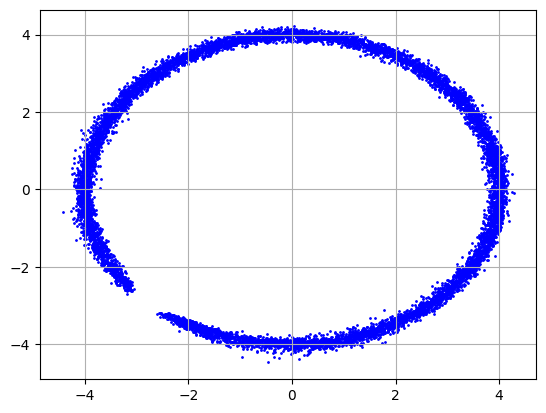

In [28]:
fig=plt.figure()
plt.scatter(trajs[:,0],trajs[:,1],color="blue",s=1)
plt.grid(True)
plt.show()

In [44]:
from Data import train_loader
from tqdm import tqdm
kl=[]
for i in tqdm(range(8)):
    batch=next(iter(train_loader))
    x,lad=RG_trained(batch)
    kl.append(KL_rel1(x,lad))
kl=torch.tensor(kl)
print(torch.mean(kl),torch.std(kl))


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

tensor(38.7126) tensor(0.1807)


In [55]:
hst = torch.histogram(trajs.cpu(),bins=1001)

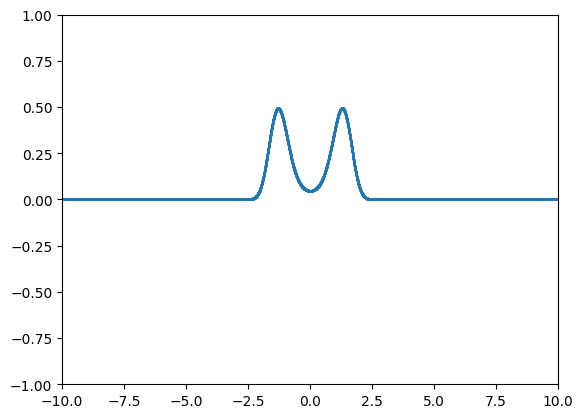

2


In [56]:
import numpy as np
import matplotlib.pyplot as plt
#A=np.array([[0,0+1j],[0-1j,0]])
#S=np.linalg.eigh(A)
#print(S)
L=10
h1=0.005
N=int(2*L/h1)
H=np.zeros((N,N))
H[0][0]=1
H[N-1][N-1]=1

for i in range(1,N-1):
    H[i][i-1]=-0.5/h1**2
    H[i][i]=(1/h1**2)+tw.V(-L+i*h1)
    H[i][i+1]=-0.5/h1**2
E=np.linalg.eigh(H)
v=np.transpose(E[1])
X=[-L+i*h1 for i in range(N)]
fig=plt.figure()
plt.axis([-L,L,-1,1])
plt.scatter(X,(v[2])**2/h1,s=1)
plt.show()
print(len(E))


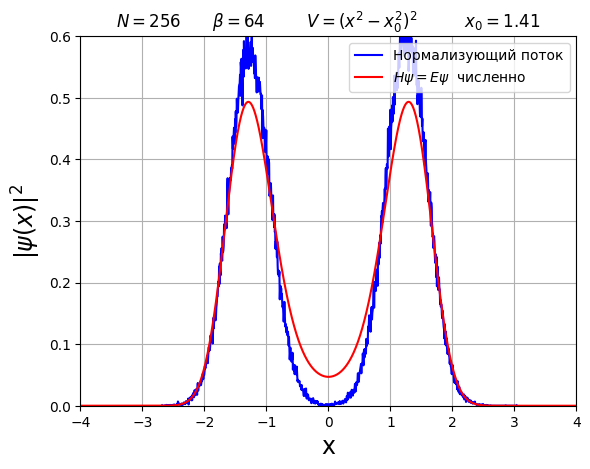

In [57]:
fig=plt.figure()
h=(hst[1][-1]-hst[1][0])/1001
plt.plot(hst[1][:-1],hst[0]/(N_nod*N_traj*h),color="blue")
plt.plot(X,(v[2])**2/h1,color="red")
plt.legend(["Нормализующий поток",r"$H\psi=E\psi$"+"  численно"])
plt.ylabel(r"$|\psi(x)|^2$",fontsize=17)
plt.xlabel("x",fontsize=17)
plt.title(r"$N=$"+str(N_nod)+"      "+r"$\beta=$"+str(Beta)+"        "+r"$V=(x^2-x_0^2)^2$"+"         "+r"$x_0=$"+str(tw.x0))
plt.axis([-4,4,0,0.6])
plt.grid(True)
plt.show()

In [45]:
trajs=trajs.numpy()

In [48]:
filename="NN rel oscillator N="+str(N_nod)+" Beta="+str(Beta)+".txt"
np.savetxt(filename,trajs,delimiter=" ")
print(filename)

NN rel oscillator N=256 Beta=16.txt


In [30]:
print(torch.mean(morse.V(trajs)),torch.std(morse.V(trajs)))

tensor(-0.4674) tensor(0.0470)


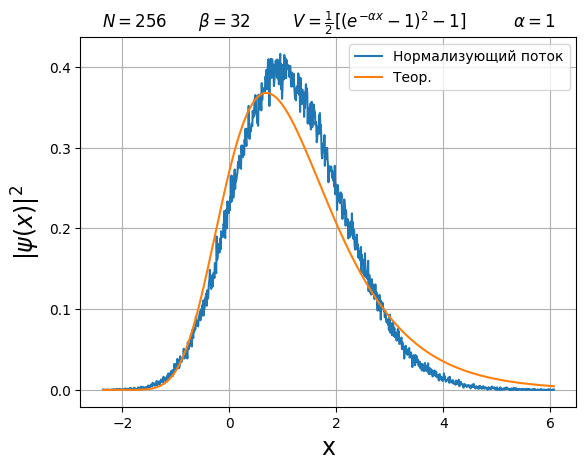

In [27]:
fig=plt.figure()
h=(hst[1][-1]-hst[1][0])/1001
plt.plot(hst[1][:-1],hst[0]/(N_nod*N_traj*h))
plt.plot(hst[1][:-1], morse.theor_Psi2(hst[1][:-1].numpy()))
plt.ylabel(r"$|\psi(x)|^2$",fontsize=17)
plt.xlabel("x",fontsize=17)
plt.title(r"$N=$"+str(N_nod)+"      "+r"$\beta=$"+str(Beta)+"        "+r"$V=\frac{1}{2}[(e^{-\alpha x}-1)^2-1]$"+"         "+r"$\alpha=$"+str(morse.alpha))
plt.legend(["Нормализующий поток","Теор."])
plt.grid(True)
plt.show()

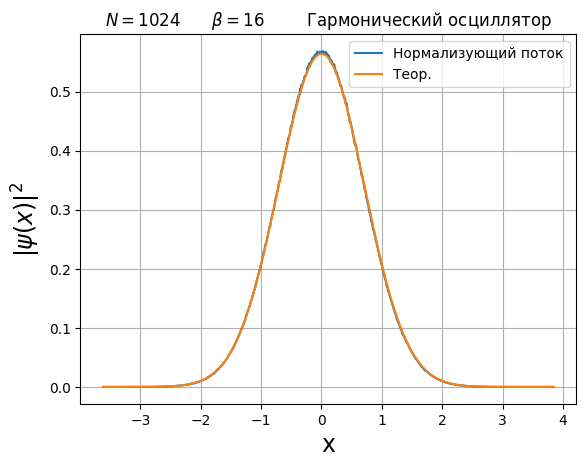

In [29]:
fig=plt.figure()
h=(hst[1][-1]-hst[1][0])/1001
plt.plot(hst[1][:-1],hst[0]/(N_nod*N_traj*h))
plt.plot(hst[1][:-1], osc.theor_Psi2(hst[1][:-1].numpy()))
plt.ylabel(r"$|\psi(x)|^2$",fontsize=17)
plt.xlabel("x",fontsize=17)
plt.title(r"$N=$"+str(N_nod)+"      "+r"$\beta=$"+str(Beta)+"        "+"Гармонический осциллятор")
plt.legend(["Нормализующий поток","Теор."])
plt.grid(True)
plt.show()

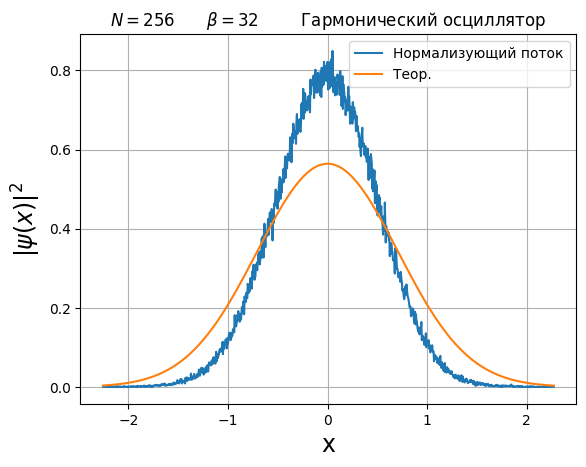

In [29]:
fig=plt.figure()
h=(hst[1][-1]-hst[1][0])/1001
plt.plot(hst[1][:-1],hst[0]/(N_nod*N_traj*h))
plt.plot(hst[1][:-1], osc.theor_Psi2(hst[1][:-1].numpy()))
plt.ylabel(r"$|\psi(x)|^2$",fontsize=17)
plt.xlabel("x",fontsize=17)
plt.title(r"$N=$"+str(N_nod)+"      "+r"$\beta=$"+str(Beta)+"        "+"Гармонический осциллятор")
plt.legend(["Нормализующий поток","Теор."])
plt.grid(True)
plt.show()

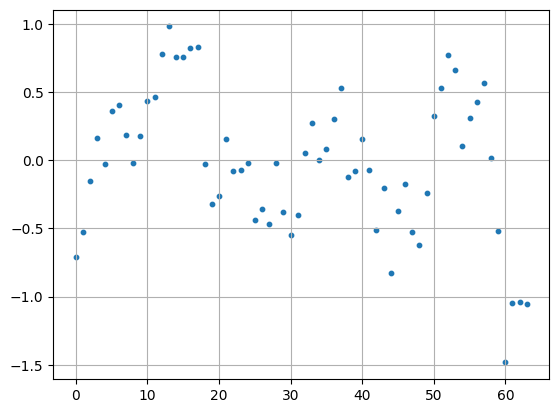

In [35]:
fig=plt.figure()
plt.scatter(list(range(N_nod)),trajs[6],s=10)
plt.grid(True)
plt.show()

In [41]:
import numpy as np
N_samp=100000
model1=RG_trained.to(device)
z=normal_dist.sample((N_samp,)).to(device)
z,_=model1(z)
k=np.arange(0,2,0.1)
print(torch.mean(torch.exp(k[0]*z)))
def W(k,z):
    f=[]
    t=0
    for i in range(len(k)):
        t=torch.mean(torch.exp(k[i]*z))
        f.append(t)
    f = torch.tensor(f)
    f = torch.log(f)
    return f
w=W(k,z)
diff=torch.roll(z,-1,1)-z
W_d=W(k,diff)
print(w)

tensor(1., device='cuda:0')
tensor([0.0000, 0.0019, 0.0075, 0.0168, 0.0297, 0.0463, 0.0665, 0.0904, 0.1179,
        0.1491, 0.1839, 0.2224, 0.2646, 0.3104, 0.3599, 0.4130, 0.4698, 0.5302,
        0.5943, 0.6621])


In [40]:
p = np.polyfit(k,w.numpy(),10)
print(p)

[ 3.77045626e-05 -3.44131416e-04  1.33907474e-03 -2.88987222e-03
  3.77425326e-03 -3.04727789e-03  1.58361970e-03 -3.10731250e-04
  5.00206066e-01 -2.13466651e-04  2.40673972e-10]


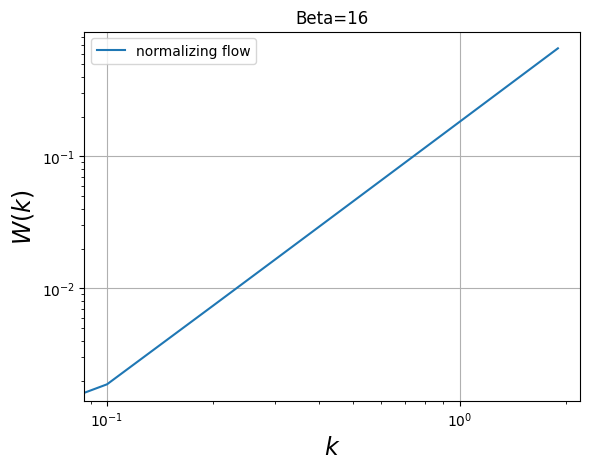

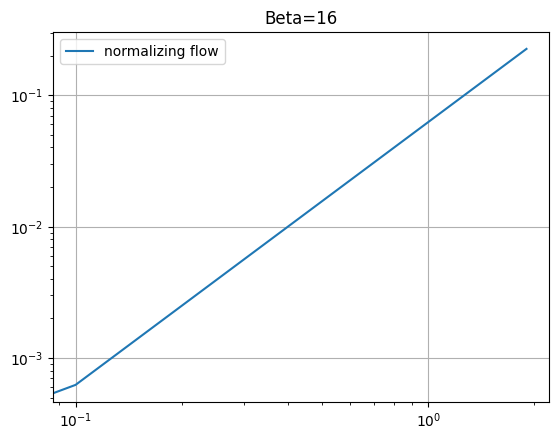

In [38]:

fig=plt.figure()
plt.plot(k,w)
#plt.plot(k,w1)
plt.legend(["normalizing flow","normalizing flow+MCMC"])
plt.xscale("log")
plt.yscale("log")
plt.title("Beta=16")
plt.ylabel(r"$W(k)$",fontsize=17)
plt.xlabel(r"$k$",fontsize=17)
plt.grid(True)
plt.show()

fig=plt.figure()
plt.plot(k,W_d)
#plt.plot(k,W_d1)
plt.legend(["normalizing flow","normalizing flow+MCMC"])
plt.xscale("log")
plt.yscale("log")
plt.title("Beta=16")
plt.grid(True)
plt.show()

In [90]:
"""
trajs=(z.cpu()).numpy()
model_name="RelColumb"
par="m=gamma=a=1"
filename="NN "+" "+model_name+" Beta="+str(Beta)+" N="+str(N_nod)+" "+par+".txt"
print(filename)
np.savetxt(filename,trajs,delimiter=" ")
"""

NN  RelColumb Beta=16 N=256 m=gamma=a=1.txt


In [71]:
"""
import numpy as np
trajs=np.genfromtxt("NN (upgraded) RelColumb Beta=16 N=1024 m=gamma=a=1.txt",delimiter=" ")
"""

In [72]:
#trajs=(torch.tensor(trajs)).float()

In [40]:
from NFandist import get_T
from tqdm import tqdm
T=torch.tensor(get_T(N_nod)).float()
def G(X,n_p=N_nod):
    G=np.zeros((n_p))
    Y=X.clone()
    Xt=torch.t(X)
    for s in tqdm(range(n_p)):
        G[s]=torch.trace(torch.matmul(Y,Xt))
        Y=torch.matmul(Y,T)
        #Y=torch.roll(Y,-1,1)
    return G/(N_traj*N_nod)
g_nf=G(trajs)



100%|██████████| 256/256 [00:00<00:00, 357.34it/s]


In [39]:
from NFandist import calc_G
from NFconstants import N_nod, N_traj, NG_points,Beta
g_osc=calc_G(N_nod,Beta,N_nod)


In [22]:
g_ur = [0.476546, 0.148654, 0.060357, 0.0232596, -0.00447499, -0.00224423, -0.00447499, 0.0232596, 0.060357, 0.148654]

In [27]:

g_ur = [0.555858, 0.497988, 0.446597, 0.401115, 0.360415, 0.324316, 0.29138, 0.261791, 0.235658, 0.211969, 0.190536, 0.171994, 0.155133, 0.140335, 0.126598, 0.114471, 0.103514, 0.0941716, 0.0852865, 0.0767528, 0.0691313, 0.0619047, 0.0550745, 0.0490998, 0.0443236, 0.0396256, 0.0358628, 0.0324961, 0.0302019, 0.0276177, 0.0251373, 0.0226234, 0.0203086, 0.0179717, 0.0164385, 0.0152739, 0.0143051, 0.0136778, 0.0127566, 0.0118486, 0.0111658, 0.0111462, 0.011026, 0.0110081, 0.0109681, 0.0106729, 0.0101027, 0.010377, 0.010866, 0.0114044, 0.0119873, 0.0114044, 0.010866, 0.010377, 0.0101027, 0.0106729, 0.0109681, 0.0110081, 0.011026, 0.0111462, 0.0111658, 0.0118486, 0.0127566, 0.0136778, 0.0143051, 0.0152739, 0.0164385, 0.0179717, 0.0203086, 0.0226234, 0.0251373, 0.0276177, 0.0302019, 0.0324961, 0.0358628, 0.0396256, 0.0443236, 0.0490998, 0.0550745, 0.0619047, 0.0691313, 0.0767528, 0.0852865, 0.0941716, 0.103514, 0.114471, 0.126598, 0.140335, 0.155133, 0.171994, 0.190536, 0.211969, 0.235658, 0.261791, 0.29138, 0.324316, 0.360415, 0.401115, 0.446597, 0.497988]


In [20]:
g_rel = [0.389004, 0.174591, 0.0750764, 0.0320855, 0.0235634, 0.0204869, 0.0235634, 0.0320855, 0.0750764, 0.174591]

In [33]:
g_rel = [0.392501, 0.361773, 0.333519, 0.307446, 0.283335, 0.261201, 0.240658, 0.221871, 0.204776, 0.188963, 0.174495, 0.161116, 0.148541, 0.136946, 0.126175, 0.116168, 0.106934, 0.0985733, 0.090693, 0.0836987, 0.0773237, 0.0713712, 0.0662134, 0.0611666, 0.0567049, 0.0525145, 0.0489322, 0.045775, 0.043085, 0.0407685, 0.0383386, 0.0365845, 0.0353032, 0.0339074, 0.0324167, 0.0308972, 0.0295226, 0.0285374, 0.0276133, 0.026899, 0.0265193, 0.0267518, 0.027023, 0.0272673, 0.0275789, 0.0277296, 0.0281657, 0.0286108, 0.0289897, 0.0292072, 0.0292838, 0.0292072, 0.0289897, 0.0286108, 0.0281657, 0.0277296, 0.0275789, 0.0272673, 0.027023, 0.0267518, 0.0265193, 0.026899, 0.0276133, 0.0285374, 0.0295226, 0.0308972, 0.0324167, 0.0339074, 0.0353032, 0.0365845, 0.0383386, 0.0407685, 0.043085, 0.045775, 0.0489322, 0.0525145, 0.0567049, 0.0611666, 0.0662134, 0.0713712, 0.0773237, 0.0836987, 0.090693, 0.0985733, 0.106934, 0.116168, 0.126175, 0.136946, 0.148541, 0.161116, 0.174495, 0.188963, 0.204776, 0.221871, 0.240658, 0.261201, 0.283335, 0.307446, 0.333519, 0.361773]


In [37]:

import numpy as np
corr = [0.0049279, 0.00445719, 0.0040318, 0.00364688, 0.00329375, 0.00297512, 0.00268571, 0.00242197, 0.00217813, 0.00195686, 0.00176504, 0.001597, 0.0014406, 0.00130362, 0.00117932, 0.00107197, 0.000971531, 0.000873839, 0.000783014, 0.000698531, 0.000622945, 0.000554938, 0.000497423, 0.000446639, 0.000400234, 0.000360026, 0.000325092, 0.00028936, 0.000252744, 0.000222755, 0.00019756, 0.000178826, 0.000169581, 0.000165766, 0.000161208, 0.000158499, 0.000157808, 0.000156267, 0.000155463, 0.000151827, 0.000137475, 0.000124214, 0.000113485, 0.000104859, 9.63436e-05, 8.8317e-05, 8.17296e-05, 7.9884e-05, 7.83747e-05, 8.01024e-05, 8.44507e-05, 8.01024e-05, 7.83747e-05, 7.9884e-05, 8.17296e-05, 8.8317e-05, 9.63436e-05, 0.000104859, 0.000113485, 0.000124214, 0.000137475, 0.000151827, 0.000155463, 0.000156267, 0.000157808, 0.000158499, 0.000161208, 0.000165766, 0.000169581, 0.000178826, 0.00019756, 0.000222755, 0.000252744, 0.00028936, 0.000325092, 0.000360026, 0.000400234, 0.000446639, 0.000497423, 0.000554938, 0.000622945, 0.000698531, 0.000783014, 0.000873839, 0.000971531, 0.00107197, 0.00117932, 0.00130362, 0.0014406, 0.001597, 0.00176504, 0.00195686, 0.00217813, 0.00242197, 0.00268571, 0.00297512, 0.00329375, 0.00364688, 0.0040318, 0.00445719, 0.0049279]
g_rel_001=(100*np.array(corr))[:-1]



In [28]:
import numpy as np
corr = [0.0482165, 0.0437875, 0.0397512, 0.0361339, 0.0328051, 0.0297607, 0.0270138, 0.0244825, 0.0222039, 0.0201489, 0.0183026, 0.0166458, 0.0151002, 0.0137192, 0.012421, 0.0112716, 0.0102497, 0.00931179, 0.0084281, 0.00763501, 0.00697282, 0.00637519, 0.00579578, 0.00524782, 0.00469027, 0.00419239, 0.00376016, 0.00335117, 0.00299975, 0.00265075, 0.00236496, 0.00215769, 0.00196452, 0.00178665, 0.00162977, 0.00148276, 0.00135563, 0.00127519, 0.00120796, 0.00115448, 0.0011155, 0.00109623, 0.00112555, 0.00113097, 0.00108849, 0.00108302, 0.00112726, 0.00115736, 0.00118966, 0.00124266, 0.00121678, 0.00124266, 0.00118966, 0.00115736, 0.00112726, 0.00108302, 0.00108849, 0.00113097, 0.00112555, 0.00109623, 0.0011155, 0.00115448, 0.00120796, 0.00127519, 0.00135563, 0.00148276, 0.00162977, 0.00178665, 0.00196452, 0.00215769, 0.00236496, 0.00265075, 0.00299975, 0.00335117, 0.00376016, 0.00419239, 0.00469027, 0.00524782, 0.00579578, 0.00637519, 0.00697282, 0.00763501, 0.0084281, 0.00931179, 0.0102497, 0.0112716, 0.012421, 0.0137192, 0.0151002, 0.0166458, 0.0183026, 0.0201489, 0.0222039, 0.0244825, 0.0270138, 0.0297607, 0.0328051, 0.0361339, 0.0397512, 0.0437875, 0.0482165]
g_rel_01=(10*np.array(corr))[:-1]


0.1940644836425781


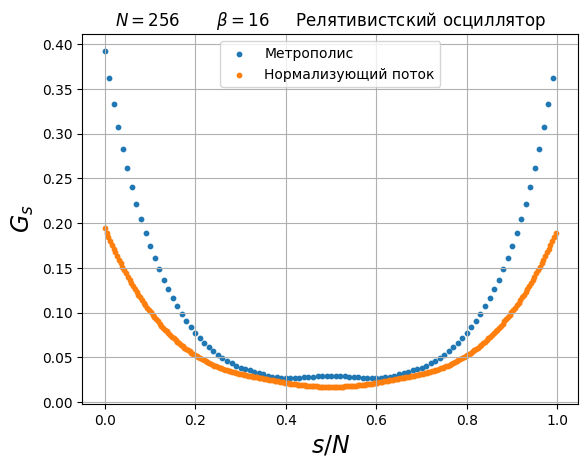

In [41]:
#import sys
#sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,Beta
#from Value import G
#import ensemble
#from NFoscillator import basic_oscillator
#from time import time
#from NFandist import calc_G

"""
ens_nf=ensemble.ensemble.load("nf_ensemble.txt",basic_oscillator)
g_nf=np.vstack(ensemble.ensemble.Vaverage_and_sigma(ens_nf,G))
g_nf=g_nf.transpose()[0]
"""

g=g_rel
print(g_nf[0])
fig=plt.figure()
MCMC_list=np.arange(len(g))/len(g)
NF_list=np.arange(len(g_nf))/len(g_nf)



plt.scatter(MCMC_list,g,s=10)
plt.scatter(NF_list,g_nf,s=10)
#plt.scatter(list(range(10)),g_nf[:10],s=5)
#plt.scatter(list(range(10)),g[:10],s=5)
#plt.scatter(NF_list,g4_nf)
plt.legend(["Метрополис","Нормализующий поток"])
#plt.legend(["normalizing flow"])
plt.title(r"$N=$"+str(N_nod)+"       "r"$\beta=$"+str(Beta)+"     Релятивистский осциллятор")
plt.ylabel(r"$G_s$",fontsize=17)
plt.xlabel(r"$s/N$",fontsize=17)
#plt.yscale("log")
plt.grid(True)
plt.show()


In [36]:
K = (1 - 2 * (g_nf[0]-g_nf[1]) / a) / (2 * a)

In [37]:
print(K)

0.6169781249999993


In [71]:
print(g_nf[0])

5.18225859375


In [3]:


! du -sh logs






20K	logs


In [4]:
! rm -rf logs


In [30]:
import time
class MCMC:
    def __init__(self,system,model="none",d=(a/N_nod)**0.5,N_sweep=100,log_per=1000):
        
        self.system = system
        self.S = 0
        self.model = model
        self.d = d
        self.N_sweep = N_sweep
        self.log_per = log_per
        self.ar = 0
        self.shift_dist = torch.distributions.Uniform(torch.zeros(N_nod), torch.ones(N_nod))
        self.un = torch.distributions.Uniform(0, 1)
        self.res=[]
        self.times=[]
        
    def sweep(self,z):
        shift = self.shift_dist.sample((N_samp,)).to(z.device)
        y = z+self.d*(2*shift-1)
    
        S_new=self.calc_S(y)
    
        dS=S_new-self.S
        prob = torch.exp(-dS)
        #prob=torch.zeros((N_samp))
        ind = self.un.sample((N_samp,)).to(z.device)<prob
    
        mask=ind.nonzero()
        if len(mask)>1:
            mask=mask.squeeze()
    
        if  len(mask)>0:
            self.S[mask]=S_new[mask]
            z[mask,:]=y[mask,:]  
        self.ar = torch.mean(ind.type('torch.FloatTensor'))           
    
    
    def log(self,z):
        if self.model=="none":
            x1=z
        else:    
            x1,_=self.model(z)
        print(torch.mean(x1**2),self.ar)
        self.res.append(torch.mean(x1**2).cpu())
        self.Times.append(time.time()-self.start)
    
    def calc_S(self,z):
        if self.model=="none":
            S=self.system.Full_S(z).to(z.device)
        else:
            x , lad = self.model(z)
            S=self.system.Full_S(x).to(z.device)-lad   
        return S
    
    def init_state(self,z):
        self.start=time.time()
        self.S=self.calc_S(z)
        self.res=[]
        self.Times=[]
        
    
    def run(self,z):
        
        self.init_state(z)
    
        for i in range(self.N_sweep):
            if i%self.log_per==0:
                self.log(z)
            self.sweep(z)
        
        return z    
    
    
        

In [41]:
N_samp=16
model1=RG_trained.to(device)
z=normal_dist.sample((N_samp,)).to(device)
z,_=model1(z)
Metropolis = MCMC(rel1,d=0.5*(a/N_nod)**0.5,N_sweep=100000,log_per=1000)
#z=torch.zeros((N_samp,N_nod)).to(device)
z = Metropolis.run(z)

tensor(0.2309, device='cuda:0') 0
tensor(0.2279, device='cuda:0') tensor(0.5000)
tensor(0.2305, device='cuda:0') tensor(0.3125)
tensor(0.2317, device='cuda:0') tensor(0.5625)
tensor(0.2335, device='cuda:0') tensor(0.6250)
tensor(0.2340, device='cuda:0') tensor(0.5625)
tensor(0.2343, device='cuda:0') tensor(0.3750)
tensor(0.2359, device='cuda:0') tensor(0.5625)
tensor(0.2377, device='cuda:0') tensor(0.5000)


KeyboardInterrupt: 

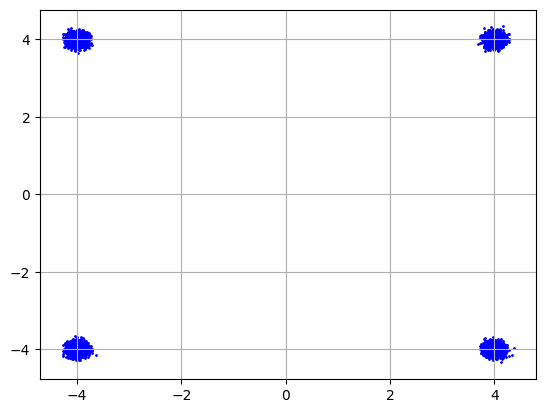

In [72]:
fig=plt.figure()
plt.scatter(z[:,0],z[:,1],color="blue",s=1)
plt.grid(True)
plt.show()

In [36]:
import time
class HMC:
    def __init__(self,system,eps=0.001,n_steps=10,sigma=1,N_sweep=100,log_per=1000):
        self.system = system
        self.S = 0
        #self.model = model
        self.eps = eps
        self.n_steps = n_steps
        self.N_sweep = N_sweep
        self.log_per = log_per
        self.ar = 0
        self.shift_dist = torch.distributions.Normal(torch.zeros(N_nod), sigma * torch.ones(N_nod))
        self.un = torch.distributions.Uniform(0, 1)
        self.res=[]
        self.times=[]
    
    def leapfrog_step(F,p,x,eps):
        p_half = p + 0.5 * eps * F(x)  # F=-dV/dx
        y = x + eps * p_half
        q = p_half + eps * F(x)
        return q, y

    def hmc_new(self,p,x):
        
        for i in range(self.n_steps):
            p , x = HMC.leapfrog_step(self.system.F,p,x,self.eps)
        return p,x       


    def hmc_sweep(self,x):
        p = self.shift_dist.sample((N_samp,)).to(x.device)
        q , y = self.hmc_new(p,x)
        S_new = self.calc_S(y)
        dS = S_new-self.S + torch.mean(q**2/2-p**2/2,axis=1)
        prob = torch.exp(-dS)
        ind = self.un.sample((N_samp,)).to(x.device)<prob
        mask = ind.nonzero()
        if len(mask)>1:
            mask = mask.squeeze()
        if  len(mask)>0:
            self.S[mask] = S_new[mask]
            x[mask,:] = y[mask,:]
        self.ar = torch.mean(ind.type('torch.FloatTensor'))    
    
    
    def log(self,z):
        x1=z
        print(torch.mean(x1**2),self.ar)
        self.res.append(torch.mean(x1**2).cpu())
        self.Times.append(time.time()-self.start)
    
    def calc_S(self,z):
        S=self.system.Full_S(z).to(z.device)   
        return S
    
    def init_state(self,z):
        self.start=time.time()
        self.S=self.calc_S(z)
        self.res=[]
        self.Times=[]

    def run(self,x):
        self.init_state(x)
        for i in range(self.N_sweep):
            if i%self.log_per==0:
                self.log(x)
            self.hmc_sweep(x)
        return x         

In [37]:
N_samp=1000
model1=RG_trained.to(device)
cold=torch.zeros((N_samp,N_nod))
z=normal_dist.sample((N_samp,)).to(device)
z,_=model1(z)
HMC_NN = HMC(rel1,N_sweep=100000,log_per=1000)
HMC_cold = HMC(rel1,N_sweep=100000,log_per=1000)
#z=torch.zeros((N_samp,N_nod)).to(device)
z = HMC_NN.run(z)
cold = HMC_cold.run(cold)

tensor(0.2798) 0
tensor(0.2851) tensor(0.7620)
tensor(0.2921) tensor(0.7730)
tensor(0.2970) tensor(0.7850)
tensor(0.3012) tensor(0.7610)
tensor(0.3058) tensor(0.7680)
tensor(0.3103) tensor(0.7760)
tensor(0.3147) tensor(0.7460)
tensor(0.3193) tensor(0.7670)
tensor(0.3209) tensor(0.7740)
tensor(0.3239) tensor(0.7410)
tensor(0.3272) tensor(0.7800)
tensor(0.3325) tensor(0.7660)
tensor(0.3346) tensor(0.7600)
tensor(0.3374) tensor(0.7760)
tensor(0.3417) tensor(0.7670)
tensor(0.3427) tensor(0.7830)
tensor(0.3469) tensor(0.7680)
tensor(0.3481) tensor(0.7790)
tensor(0.3484) tensor(0.7650)
tensor(0.3510) tensor(0.7740)
tensor(0.3524) tensor(0.7750)
tensor(0.3528) tensor(0.7760)
tensor(0.3531) tensor(0.7690)
tensor(0.3539) tensor(0.8060)
tensor(0.3568) tensor(0.7790)
tensor(0.3569) tensor(0.7970)
tensor(0.3586) tensor(0.7720)
tensor(0.3578) tensor(0.7550)
tensor(0.3600) tensor(0.7760)
tensor(0.3632) tensor(0.7700)
tensor(0.3659) tensor(0.7900)
tensor(0.3689) tensor(0.7660)
tensor(0.3718) tensor(0

In [ ]:
#z=MCMC(rel_columb,z,model=RG_trained.to(z.device),d=5*(a/N_nod)**0.5,N_sweep=5000)

In [49]:
trajs,_=model1(z)

In [73]:
from NFandist import calc_G
from NFconstants import N_nod, N_traj, NG_points,Beta
#g_osc=calc_G(N_nod,Beta,N_nod)
g_nf=G(z)
#g_nf=G(RG_trained(z)[0])
#print(g_nf-g_ur)

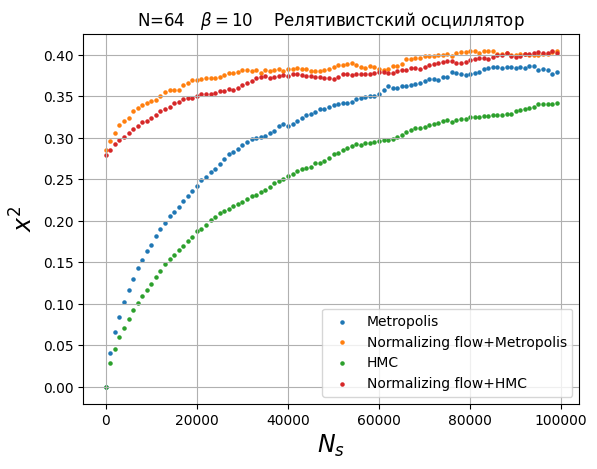

In [57]:
#import sys
#sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,Beta
#from Value import G
#import ensemble
#from NFoscillator import basic_oscillator
#from time import time
#from NFandist import calc_G

"""
ens_nf=ensemble.ensemble.load("nf_ensemble.txt",basic_oscillator)
g_nf=np.vstack(ensemble.ensemble.Vaverage_and_sigma(ens_nf,G))
g_nf=g_nf.transpose()[0]
"""

"""
#g=g_ur
print(g_nf[0])
fig=plt.figure()
#MCMC_list=np.arange(len(g))/len(g)
NF_list=np.arange(len(g_nf))/len(g_nf)
#plt.scatter(MCMC_list,g)
plt.scatter(NF_list,g_nf)
#plt.scatter(NF_list,g4_nf)
plt.legend(["MCMC","normalizing flow"])
#plt.legend(["normalizing flow"])
plt.title("Beta=16")
plt.grid(True)
plt.show()
"""


fig=plt.figure()
#l=[g_rel[0]]*len(latTimes)

plt.scatter(np.arange(0,100000,1000) ,Metropolis_cold.res,s=5)
plt.scatter(np.arange(0,100000,1000) ,Metropolis_NN.res,s=5)
plt.scatter(np.arange(0,100000,1000) ,HMC_cold.res,s=5)
plt.scatter(np.arange(0,100000,1000) ,HMC_NN.res,s=5)
#plt.scatter(phTimes,phres,s=1)
#plt.xscale("log")
plt.xlabel(r"$N_s$",fontsize=17)
plt.ylabel(r"$x^2$",fontsize=17)
plt.legend(["Metropolis","Normalizing flow+Metropolis","HMC","Normalizing flow+HMC"])
plt.title("N=64"+"   "+r"$\beta=$"+str(Beta)+"    Релятивистский осциллятор")
#plt.scatter(latTimes,l,s=1)
plt.grid(True)
plt.show()

In [3]:
kl=np.genfromtxt("KL_ur.txt")

In [4]:
kl=kl.transpose()

In [5]:
kl

array([[5.12000000e+02, 2.56000000e+02, 1.28000000e+02, 6.40000000e+01,
        3.20000000e+01, 1.60000000e+01, 8.00000000e+00],
       [9.63520203e+01, 5.03314438e+01, 2.79312916e+01, 1.78563347e+01,
        1.39471130e+01, 1.25200195e+01, 1.14711685e+01],
       [3.61843795e-01, 1.74091488e-01, 2.57185966e-01, 1.11024015e-01,
        7.48867616e-02, 9.41358134e-02, 3.88195813e-02]])

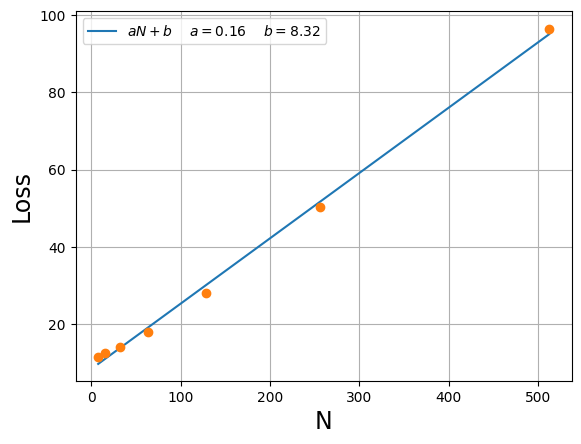

8.324237527518441


In [42]:
fig=plt.figure
linear_model = np.polyfit(kl[0], kl[1], 1)
linear_model_fn = np.poly1d(linear_model)
plt.plot(kl[0],linear_model_fn(kl[0]))
plt.legend([r"$aN+b$"+"    "+r"$a=$"+str(linear_model[0])[:4]+"    "+r"$b=$"+str(linear_model[1])[:4]])
plt.grid(True)
plt.xlabel("N",fontsize=17)
plt.ylabel("Loss",fontsize=17)
plt.errorbar(kl[0], kl[1], yerr=kl[2], fmt='o')
plt.show()
print(str(linear_model[1]))